# NBA Home-Team-Win — Logistic Regression (Optuna-Tuned)
This notebook loads your existing dataset from SQLite, tunes a **Logistic Regression** model with **Optuna**, and produces rich evaluation: confusion matrix, classification report, ROC/PR curves, calibration, and learning curves to diagnose potential overfitting.

**Data**: `Data/dataset.sqlite` → table `dataset_2012-24_new` with target `Home-Team-Win`.
**Features**: all numeric columns (non-numerics dropped).
**CV**: Stratified K-Fold.


In [18]:
# If Optuna isn't installed, uncomment:
# %pip install optuna

# Optional: if lightgbm is present, we won't use it here, but it's fine.
# %pip install scikit-learn

import sqlite3
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, brier_score_loss, accuracy_score, log_loss,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression

import optuna
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 180)


In [19]:
# === Paths and table ===
DB_PATH = Path('/Users/aidenflynn/BET-DASHBOARD/python-nba-2026/Data/dataset.sqlite')
TABLE_NAME = 'dataset_2012P'
TARGET_COL = 'Home-Team-Win'

assert DB_PATH.exists(), f"SQLite not found at {DB_PATH}"
print(f"Using DB: {DB_PATH}, table: {TABLE_NAME}")

Using DB: /Users/aidenflynn/BET-DASHBOARD/python-nba-2026/Data/dataset.sqlite, table: dataset_2012P


In [20]:
# === Load data ===
with sqlite3.connect(DB_PATH) as con:
    # df = pd.read_sql_query(f'SELECT * FROM "{TABLE_NAME}" where Date > "2015-10-01"', con)
    df = pd.read_sql_query(f'SELECT * FROM "{TABLE_NAME}"', con)

print(df.shape)
df.head(3)

(15552, 118)


,index,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,Date,TEAM_NAME.1,GP.1,W.1,L.1,W_PCT.1,MIN.1,FGM.1,FGA.1,FG_PCT.1,FG3M.1,FG3A.1,FG3_PCT.1,FTM.1,FTA.1,FT_PCT.1,OREB.1,DREB.1,REB.1,AST.1,TOV.1,STL.1,BLK.1,BLKA.1,PF.1,PFD.1,PTS.1,PLUS_MINUS.1,GP_RANK.1,W_RANK.1,L_RANK.1,W_PCT_RANK.1,MIN_RANK.1,FGM_RANK.1,FGA_RANK.1,FG_PCT_RANK.1,FG3M_RANK.1,FG3A_RANK.1,FG3_PCT_RANK.1,FTM_RANK.1,FTA_RANK.1,FT_PCT_RANK.1,OREB_RANK.1,DREB_RANK.1,REB_RANK.1,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Date.1,Score,Home-Team-Win,OU,OU-Cover,Days-Rest-Home,Days-Rest-Away,Spread,Win_Margin,ATS_Cover
0,0,New York Knicks,1.0,1.0,0.0,1.0,48.0,36.0,84.0,0.429,19.0,36.0,0.528,13.0,15.0,0.867,13.0,28.0,41.0,27.0,14.0,10.0,0.0,5.0,22.0,18.0,104.0,20.0,25.0,12.0,1.0,1.0,5.0,14.0,14.0,17.0,1.0,1.0,1.0,26.0,30.0,2.0,8.0,27.0,20.0,2.0,9.0,7.0,30.0,12.0,19.0,24.0,5.0,1.0,2012-11-04,Philadelphia 76ers,1.0,1.0,0.0,1.0,48.0,30.0,85.0,0.353,7.0,25.0,0.280,17.0,21.0,0.810,14.0,33.0,47.0,18.0,16.0,13.0,11.0,5.0,14.0,22.0,84.0,9.0,25.0,12.0,1.0,1.0,5.0,30.0,11.0,30.0,8.0,4.0,22.0,14.0,19.0,7.0,6.0,8.0,7.0,25.0,17.0,1.0,1.0,12.0,1.0,10.0,30.0,5.0,2012-11-04,184.0,1.0,188.0,0.0,2.0,4.0,4.5,16.0,1.0
1,0,Washington Wizards,1.0,0.0,1.0,0.0,48.0,41.0,95.0,0.432,7.0,36.0,0.194,13.0,18.0,0.722,10.0,30.0,40.0,27.0,15.0,9.0,6.0,3.0,19.0,19.0,102.0,-20.0,3.0,16.0,15.0,16.0,3.0,14.0,8.0,21.0,28.0,14.0,28.0,27.0,26.0,22.0,20.0,23.0,24.0,9.0,16.0,9.0,14.0,7.0,10.0,21.0,27.0,27.0,2024-10-24,Boston Celtics,2.0,2.0,0.0,1.0,48.0,45.0,92.5,0.486,23.0,53.0,0.434,14.0,17.5,0.800,11.5,33.0,44.5,27.0,9.0,6.5,3.0,4.5,17.0,15.5,127.0,21.5,1.0,1.0,1.0,1.0,3.0,3.0,11.0,9.0,1.0,1.0,2.0,26.0,27.0,5.0,19.0,15.0,15.0,9.0,3.0,21.0,23.0,11.0,5.0,27.0,3.0,3.0,2024-10-24,224.0,0.0,231.0,0.0,7.0,2.0,-14.0,-20.0,0.0
2,1,Dallas Mavericks,1.0,1.0,0.0,1.0,48.0,42.0,102.0,0.412,19.0,44.0,0.432,17.0,23.0,0.739,17.0,33.0,50.0,27.0,10.0,9.0,5.0,5.0,21.0,18.0,120.0,11.0,3.0,2.0,1.0,1.0,3.0,9.0,2.0,26.0,3.0,6.0,4.0,22.0,21.0,19.0,2.0,15.0,7.0,9.0,5.0,9.0,17.0,12.0,13.0,23.0,8.0,8.0,2024-10-24,San Antonio Spurs,1.0,0.0,1.0,0.0,48.0,39.0,86.0,0.453,12.0,36.0,0.333,19.0,24.0,0.792,12.0,40.0,52.0,30.0,19.0,6.0,5.0,5.0,18.0,21.0,109.0,-11.0,3.0,16.0,15.0,16.0,3.0,19.0,18.0,15.0,14.0,14.0,17.0,16.0,19.0,11.0,15.0,3.0,5.0,3.0,25.0,22.0,17.0,12.0,7.0,15.0,20.0,22.0,2024-10-24,229.0,1.0,227.5,1.0,7.0,7.0,8.5,11.0,1.0


In [21]:
# === Prepare features/target ===
assert TARGET_COL in df.columns
y = df[TARGET_COL].astype(int).values

# keep numeric features only; drop target and common non-features
# non_feature_cols = {TARGET_COL, 'index','Date','Home','Away','OU','OU-Cover','TEAM_HOME','TEAM_AWAY','TEAM_HOME_ID','TEAM_AWAY_ID', 'TEAM_NAME', 'TEAM_NAME.1','Score','Win_Margin','Spread','ATS_Cover'}
# X_df = df.drop(columns=[c for c in df.columns if c in non_feature_cols], errors='ignore').select_dtypes(include=['number']).copy()

# keep numeric features only; drop target and common non-features
non_feature_cols = {
    TARGET_COL, 'index','Date','Home','Away','OU','OU-Cover',
    'TEAM_HOME','TEAM_AWAY','TEAM_HOME_ID','TEAM_AWAY_ID',
    'TEAM_NAME', 'TEAM_NAME.1','Score','Win_Margin','Spread','ATS_Cover'
}

# drop explicit non-features + any *_RANK columns
drop_cols = [
    c for c in df.columns
    if (c in non_feature_cols) or ("_RANK" in c)
]

X_df = (
    df
    .drop(columns=drop_cols, errors='ignore')
    .select_dtypes(include=['number'])
    .copy()
)

feature_names = X_df.columns.tolist()
print(feature_names)
assert len(feature_names) > 0, "No numeric features found"
X = X_df.values
print(f"X: {X.shape}, y positive rate (home win): {y.mean():.3f}")

['GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'GP.1', 'W.1', 'L.1', 'W_PCT.1', 'MIN.1', 'FGM.1', 'FGA.1', 'FG_PCT.1', 'FG3M.1', 'FG3A.1', 'FG3_PCT.1', 'FTM.1', 'FTA.1', 'FT_PCT.1', 'OREB.1', 'DREB.1', 'REB.1', 'AST.1', 'TOV.1', 'STL.1', 'BLK.1', 'BLKA.1', 'PF.1', 'PFD.1', 'PTS.1', 'PLUS_MINUS.1', 'Days-Rest-Home', 'Days-Rest-Away']
X: (15552, 54), y positive rate (home win): 0.574


In [22]:
# === Train/Test split ===
# We keep a holdout test set for final evaluation; CV is on the training fold.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape)

(12441, 54) (3111, 54)


In [23]:
# === Objective for Optuna ===
def make_pipeline(C, penalty, l1_ratio=None, class_weight=None, max_iter=5000):
    # saga supports l1, l2, elasticnet
    if penalty == 'elasticnet':
        clf = LogisticRegression(
            solver='saga', penalty='elasticnet', C=C, l1_ratio=l1_ratio,
            max_iter=max_iter, class_weight=class_weight
        )
    elif penalty == 'l1':
        clf = LogisticRegression(
            solver='saga', penalty='l1', C=C, max_iter=max_iter, class_weight=class_weight
        )
    else:  # 'l2'
        clf = LogisticRegression(
            solver='lbfgs', penalty='l2', C=C, max_iter=max_iter, class_weight=class_weight
        )
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('clf', clf)
    ])
    return pipe

def objective(trial):
    # search space
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet'])
    C = trial.suggest_float('C', 1e-3, 1.0, log=True)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    pipe = make_pipeline(C=C, penalty=penalty, l1_ratio=l1_ratio, class_weight=class_weight, max_iter=5000)

    # 5-fold stratified CV on training portion
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs, briers, accs, logs = [], [], [], []

    for tr, te in skf.split(X_train, y_train):
        pipe.fit(X_train[tr], y_train[tr])
        proba = pipe.predict_proba(X_train[te])[:,1]
        pred = (proba >= 0.5).astype(int)

        aucs.append(roc_auc_score(y_train[te], proba))
        briers.append(brier_score_loss(y_train[te], proba))
        accs.append(accuracy_score(y_train[te], pred))
        logs.append(log_loss(y_train[te], np.clip(proba, 1e-6, 1-1e-6)))

    # multi-metric optimization: primarily AUC, then Brier
    # Combine as: maximize (AUC - Brier) for a single scalar.
    score = float(np.mean(aucs) - np.mean(briers))
    trial.set_user_attr('AUC_mean', float(np.mean(aucs)))
    trial.set_user_attr('Brier_mean', float(np.mean(briers)))
    trial.set_user_attr('Acc_mean', float(np.mean(accs)))
    trial.set_user_attr('LogLoss_mean', float(np.mean(logs)))
    return score

In [24]:
# === Run Optuna study ===
study = optuna.create_study(direction='maximize', study_name='logreg_homewin')
study.optimize(objective, n_trials=40, n_jobs=1, show_progress_bar=True)

print("Best value (AUC - Brier):", study.best_value)
print("Best params:")
print(study.best_params)

# Summarize top trials
df_trials = study.trials_dataframe(attrs=('number','value','params','user_attrs'))
df_trials.sort_values('value', ascending=False).head(10)

[I 2026-01-01 18:17:01,455] A new study created in memory with name: logreg_homewin


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2026-01-01 18:17:02,575] Trial 0 finished with value: 0.4802589163665155 and parameters: {'penalty': 'l1', 'C': 0.016784898662206862, 'class_weight': None}. Best is trial 0 with value: 0.4802589163665155.
[I 2026-01-01 18:17:06,101] Trial 1 finished with value: 0.47923839337444546 and parameters: {'penalty': 'l1', 'C': 0.22796485881292963, 'class_weight': None}. Best is trial 0 with value: 0.4802589163665155.
[I 2026-01-01 18:17:16,837] Trial 2 finished with value: 0.47894370689591736 and parameters: {'penalty': 'l1', 'C': 0.8154019859968159, 'class_weight': None}. Best is trial 0 with value: 0.4802589163665155.
[I 2026-01-01 18:17:17,112] Trial 3 finished with value: 0.47795229925409455 and parameters: {'penalty': 'l2', 'C': 0.0013124655632521882, 'class_weight': None}. Best is trial 0 with value: 0.4802589163665155.
[I 2026-01-01 18:17:17,414] Trial 4 finished with value: 0.4745659385736741 and parameters: {'penalty': 'l2', 'C': 0.003679587749984046, 'class_weight': 'balanced'}. B

,number,value,params_C,params_class_weight,params_l1_ratio,params_penalty,user_attrs_AUC_mean,user_attrs_Acc_mean,user_attrs_Brier_mean,user_attrs_LogLoss_mean
32,32,0.480316,0.023951,None,NaN,l1,0.696712,0.651876,0.216396,0.622117
31,31,0.480315,0.024649,None,NaN,l1,0.696707,0.651956,0.216392,0.622103
35,35,0.480311,0.020425,None,NaN,l1,0.696738,0.652358,0.216427,0.622212
27,27,0.480287,0.027255,None,NaN,l1,0.696666,0.652599,0.216379,0.622062
22,22,0.480267,0.027959,None,NaN,l1,0.696645,0.652921,0.216377,0.622054
0,0,0.480259,0.016785,None,NaN,l1,0.696765,0.651635,0.216506,0.622435
25,25,0.480232,0.029983,None,NaN,l1,0.696606,0.652841,0.216373,0.622037
34,34,0.480220,0.030821,None,NaN,l1,0.696591,0.653001,0.216371,0.622030
12,12,0.480196,0.031447,None,NaN,l1,0.696566,0.652921,0.216369,0.622024
23,23,0.480111,0.035309,None,NaN,l1,0.696478,0.652921,0.216366,0.622005


In [25]:
# === Train final model on full training set with best params ===
bp = study.best_params
penalty = bp.get('penalty','l2')
C = float(bp.get('C', 1.0))
class_weight = bp.get('class_weight', None)
l1_ratio = bp.get('l1_ratio', None) if penalty == 'elasticnet' else None

final_pipe = make_pipeline(C=C, penalty=penalty, l1_ratio=l1_ratio, class_weight=class_weight, max_iter=1000)
final_pipe.fit(X_train, y_train)

# Evaluate on train and test for overfitting diagnostics
proba_tr = final_pipe.predict_proba(X_train)[:,1]
proba_te = final_pipe.predict_proba(X_test)[:,1]
pred_tr = (proba_tr >= 0.5).astype(int)
pred_te = (proba_te >= 0.5).astype(int)

def summarize(y_true, proba, pred, label):
    print(f"\n=== {label} ===")
    print("AUC:", roc_auc_score(y_true, proba))
    print("Brier:", brier_score_loss(y_true, proba))
    print("Accuracy:", accuracy_score(y_true, pred))
    print("LogLoss:", log_loss(y_true, np.clip(proba, 1e-6, 1-1e-6)))

summarize(y_train, proba_tr, pred_tr, "Train")
summarize(y_test,  proba_te, pred_te,  "Test")


=== Train ===
AUC: 0.7007295165953231
Brier: 0.21520699791234787
Accuracy: 0.6535648259786191
LogLoss: 0.6193944282187019

=== Test ===
AUC: 0.7013556281773197
Brier: 0.2157974968349095
Accuracy: 0.6563805850208936
LogLoss: 0.6204120368010791


[(0.2862264436116448, 0.2980769230769231), (0.4025817701739001, 0.3729903536977492), (0.46605208477130183, 0.4405144694533762), (0.5193057059460832, 0.4694533762057878), (0.5641777199108078, 0.5594855305466238), (0.6082050178342103, 0.639871382636656), (0.6473528738383645, 0.6334405144694534), (0.6957225072256962, 0.707395498392283), (0.7479409610893969, 0.752411575562701), (0.8318293497131757, 0.8713826366559485)]


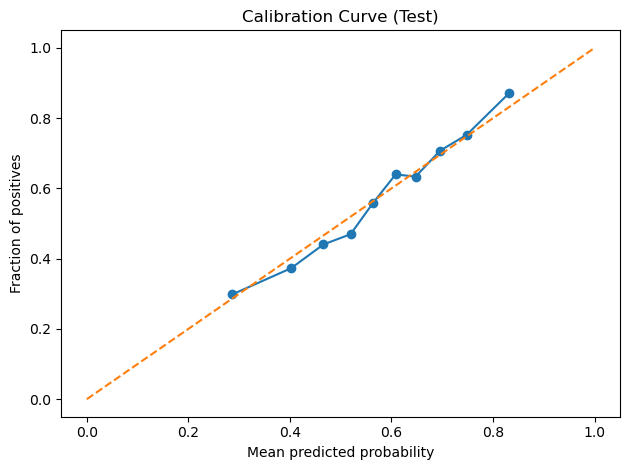

In [26]:
# === Calibration curve on Test ===
from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve(y_test, proba_te, n_bins=10, strategy='quantile')

print(list(zip(mean_pred, frac_pos)))

plt.figure()
plt.plot(mean_pred, frac_pos, marker='o')
plt.plot([0,1],[0,1], linestyle='--')
plt.title('Calibration Curve (Test)')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


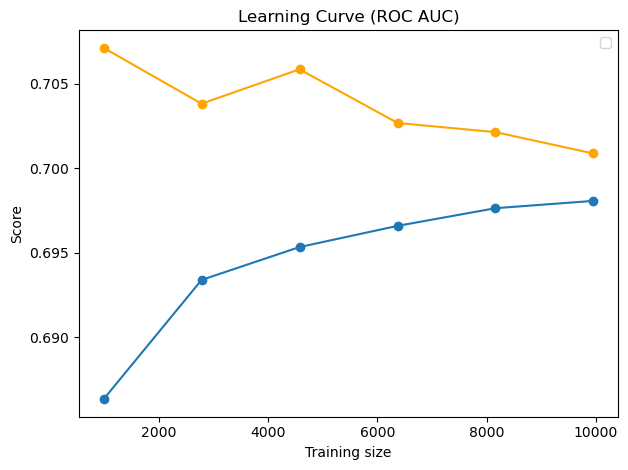

In [27]:
# === Learning curves (Train size vs score) to visualize overfitting ===
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    final_pipe, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=42
)

plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', color="orange")
plt.plot(train_sizes, val_scores.mean(axis=1), marker='o')
plt.title('Learning Curve (ROC AUC)')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# === Save the trained model ===
import joblib
from pathlib import Path

MODEL_DIR = Path("../Models")
MODEL_DIR.mkdir(exist_ok=True)
MODEL_PATH = MODEL_DIR / "homewin_logreg_final.joblib"

joblib.dump(final_pipe, MODEL_PATH)
print(f"✅ Model saved to: {MODEL_PATH.resolve()}")

# === Example: Load it later ===
loaded_pipe = joblib.load(MODEL_PATH)
probs = loaded_pipe.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)


✅ Model saved to: /Users/aidenflynn/BET-DASHBOARD/Models/homewin_logreg_final.joblib


## ROI backtest + edge-bin diagnostics (NHL-style)

This section emulates the NHL pipeline backtesting:
- converts American odds ↔ implied probability
- computes **edge** for home and away sides
- chooses the side with the best positive edge (optionally constrained)
- sizes stakes using fractional Kelly (capped)
- reports ROI, drawdown, hit rate
- breaks performance into **Home/Road × Favorite/Underdog** segments and **edge bins**

In [29]:
import numpy as np
import pandas as pd

def american_to_decimal(a):
    a = float(a)
    if a > 0:
        return 1.0 + (a / 100.0)
    else:
        return 1.0 + (100.0 / abs(a))

def implied_prob_from_american(a):
    a = float(a)
    if a > 0:
        return 100.0 / (a + 100.0)
    else:
        return abs(a) / (abs(a) + 100.0)

def kelly_fraction(p, dec_odds):
    # Kelly for a single bet with probability p and decimal odds dec_odds
    # b is net odds
    b = dec_odds - 1.0
    q = 1.0 - p
    f = (b * p - q) / b if b > 0 else 0.0
    return max(0.0, f)

def settle_moneyline_bet(side, home_win, stake, home_odds, away_odds):
    """
    side: 'home' or 'away'
    home_win: bool/int
    stake: float
    home_odds/away_odds: American odds (int/float)
    returns pnl (profit including losses, stake already outlayed)
    """
    if side == "home":
        won = bool(home_win)
        dec = american_to_decimal(home_odds)
    else:
        won = not bool(home_win)
        dec = american_to_decimal(away_odds)
    if won:
        return stake * (dec - 1.0)
    else:
        return -stake

def compute_drawdown(equity):
    eq = np.asarray(equity, dtype=float)
    if eq.size == 0:
        return 0.0
    peak = np.maximum.accumulate(eq)
    dd = (eq - peak) / peak
    return float(dd.min())

def backtest_moneylines(df_bets, bankroll0=1000.0):
    """
    df_bets must include: stake, pnl
    """
    bankroll = bankroll0
    equity = [bankroll0]
    for pnl in df_bets["pnl"].values:
        bankroll += pnl
        equity.append(bankroll)

    profit = float(df_bets["pnl"].sum()) if len(df_bets) else 0.0
    stake_sum = float(df_bets["stake"].sum()) if len(df_bets) else 0.0
    roi = profit / stake_sum if stake_sum > 0 else 0.0

    return {
        "n_bets": int(len(df_bets)),
        "profit": profit,
        "stake_sum": stake_sum,
        "roi": float(roi),
        "ending_bankroll": float(equity[-1]) if equity else bankroll0,
        "max_drawdown": compute_drawdown(equity),
        "hit_rate": float((df_bets["pnl"] > 0).mean()) if len(df_bets) else 0.0,
        "avg_edge": float(df_bets["edge"].mean()) if len(df_bets) else 0.0,
        "avg_stake": float(df_bets["stake"].mean()) if len(df_bets) else 0.0,
    }

In [30]:
df

,index,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,GP_RANK,W_RANK,L_RANK,W_PCT_RANK,MIN_RANK,FGM_RANK,FGA_RANK,FG_PCT_RANK,FG3M_RANK,FG3A_RANK,FG3_PCT_RANK,FTM_RANK,FTA_RANK,FT_PCT_RANK,OREB_RANK,DREB_RANK,REB_RANK,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,Date,TEAM_NAME.1,GP.1,W.1,L.1,W_PCT.1,MIN.1,FGM.1,FGA.1,FG_PCT.1,FG3M.1,FG3A.1,FG3_PCT.1,FTM.1,FTA.1,FT_PCT.1,OREB.1,DREB.1,REB.1,AST.1,TOV.1,STL.1,BLK.1,BLKA.1,PF.1,PFD.1,PTS.1,PLUS_MINUS.1,GP_RANK.1,W_RANK.1,L_RANK.1,W_PCT_RANK.1,MIN_RANK.1,FGM_RANK.1,FGA_RANK.1,FG_PCT_RANK.1,FG3M_RANK.1,FG3A_RANK.1,FG3_PCT_RANK.1,FTM_RANK.1,FTA_RANK.1,FT_PCT_RANK.1,OREB_RANK.1,DREB_RANK.1,REB_RANK.1,AST_RANK.1,TOV_RANK.1,STL_RANK.1,BLK_RANK.1,BLKA_RANK.1,PF_RANK.1,PFD_RANK.1,PTS_RANK.1,PLUS_MINUS_RANK.1,Date.1,Score,Home-Team-Win,OU,OU-Cover,Days-Rest-Home,Days-Rest-Away,Spread,Win_Margin,ATS_Cover
0,0,New York Knicks,1.0,1.0,0.0,1.000,48.0,36.0,84.0,0.429,19.0,36.0,0.528,13.0,15.0,0.867,13.0,28.0,41.0,27.0,14.0,10.0,0.0,5.0,22.0,18.0,104.0,20.0,25.0,12.0,1.0,1.0,5.0,14.0,14.0,17.0,1.0,1.0,1.0,26.0,30.0,2.0,8.0,27.0,20.0,2.0,9.0,7.0,30.0,12.0,19.0,24.0,5.0,1.0,2012-11-04,Philadelphia 76ers,1.0,1.0,0.0,1.000,48.0,30.0,85.0,0.353,7.0,25.0,0.280,17.0,21.0,0.810,14.0,33.0,47.0,18.0,16.0,13.0,11.0,5.0,14.0,22.0,84.0,9.0,25.0,12.0,1.0,1.0,5.0,30.0,11.0,30.0,8.0,4.0,22.0,14.0,19.0,7.0,6.0,8.0,7.0,25.0,17.0,1.0,1.0,12.0,1.0,10.0,30.0,5.0,2012-11-04,184.0,1.0,188.0,0.0,2.0,4.0,4.5,16.0,1.0
1,0,Washington Wizards,1.0,0.0,1.0,0.000,48.0,41.0,95.0,0.432,7.0,36.0,0.194,13.0,18.0,0.722,10.0,30.0,40.0,27.0,15.0,9.0,6.0,3.0,19.0,19.0,102.0,-20.0,3.0,16.0,15.0,16.0,3.0,14.0,8.0,21.0,28.0,14.0,28.0,27.0,26.0,22.0,20.0,23.0,24.0,9.0,16.0,9.0,14.0,7.0,10.0,21.0,27.0,27.0,2024-10-24,Boston Celtics,2.0,2.0,0.0,1.000,48.0,45.0,92.5,0.486,23.0,53.0,0.434,14.0,17.5,0.800,11.5,33.0,44.5,27.0,9.0,6.5,3.0,4.5,17.0,15.5,127.0,21.5,1.0,1.0,1.0,1.0,3.0,3.0,11.0,9.0,1.0,1.0,2.0,26.0,27.0,5.0,19.0,15.0,15.0,9.0,3.0,21.0,23.0,11.0,5.0,27.0,3.0,3.0,2024-10-24,224.0,0.0,231.0,0.0,7.0,2.0,-14.0,-20.0,0.0
2,1,Dallas Mavericks,1.0,1.0,0.0,1.000,48.0,42.0,102.0,0.412,19.0,44.0,0.432,17.0,23.0,0.739,17.0,33.0,50.0,27.0,10.0,9.0,5.0,5.0,21.0,18.0,120.0,11.0,3.0,2.0,1.0,1.0,3.0,9.0,2.0,26.0,3.0,6.0,4.0,22.0,21.0,19.0,2.0,15.0,7.0,9.0,5.0,9.0,17.0,12.0,13.0,23.0,8.0,8.0,2024-10-24,San Antonio Spurs,1.0,0.0,1.0,0.000,48.0,39.0,86.0,0.453,12.0,36.0,0.333,19.0,24.0,0.792,12.0,40.0,52.0,30.0,19.0,6.0,5.0,5.0,18.0,21.0,109.0,-11.0,3.0,16.0,15.0,16.0,3.0,19.0,18.0,15.0,14.0,14.0,17.0,16.0,19.0,11.0,15.0,3.0,5.0,3.0,25.0,22.0,17.0,12.0,7.0,15.0,20.0,22.0,2024-10-24,229.0,1.0,227.5,1.0,7.0,7.0,8.5,11.0,1.0
3,1,Toronto Raptors,2.0,0.0,2.0,0.000,48.0,35.0,86.5,0.405,6.5,17.5,0.371,17.5,22.0,0.795,12.5,27.0,39.5,20.5,12.0,10.0,6.5,7.5,24.5,17.5,94.0,-4.5,17.0,24.0,22.0,24.0,5.0,22.0,8.0,25.0,13.0,18.0,13.0,13.0,16.0,9.0,13.0,29.0,23.0,18.0,3.0,7.0,12.0,26.0,25.0,27.0,21.0,21.0,2012-11-04,Minnesota Timberwolves,1.0,1.0,0.0,1.000,48.0,32.0,87.0,0.368,2.0,17.0,0.118,26.0,36.0,0.722,17.0,36.0,53.0,17.0,11.0,4.0,10.0,4.0,17.0,34.0,92.0,12.0,25.0,12.0,1.0,1.0,5.0,29.0,6.0,29.0,30.0,20.0,30.0,3.0,2.0,23.0,1.0,3.0,2.0,28.0,1.0,29.0,2.0,5.0,3.0,1.0,25.0,3.0,2012-11-04,191.0,1.0,187.0,1.0,1.0,2.0,3.5,19.0,1.0
4,2,Orlando Magic,1.0,1.0,0.0,1.000,48.0,42.0,86.0,0.488,5.0,15.0,0.333,13.0,18.0,0.722,11.0,35.0,46.0,24.0,13.0,8.0,8.0,5.0,24.0,17.0,102.0,13.0,25.0,12.0,1.0,1.0,5.0,1.0,9.0,5.0,23.0,25.0,17.0,26.0,25.0,23.0,18.0,5.0,8.0,6.0,5.0,16.0,5.0,12.0,23.0,28.0,6.0,2.0,2012-11-04,Phoenix Suns,2.0,1.0,1.0,0.500,48.0,36.0,86.0,0.419,3.0,16.0,0.188,13.5,18.0,0.750,13.0,35.0,48.0,15.5,16.0,8.0,8.5,4.0,21.5,19.5,88.5,0.5,17.0,12.0,8.0,17.0,5.0,14.0,9.0,23.0,28.0,22.0,29.0,25.0,25.0,17.0,8.0,5.0,5.0,30.0,17.0,16.0,4.0,5.0,18.0,19.0,27.0,17.0,2012-11-04,209.0,1.0,194.5,1.0,2.0,2.0,1.5,21.0,1.0
...,...,...,...,...,...,...,...,...,

In [31]:
# =========================
# FINAL NBA odds merge (simple + correct)
# =========================
import json
import pandas as pd
import numpy as np

ODDS_JSON_PATH = "nba_moneylines_2023_2025.json"
TEST_START_DATE = pd.to_datetime("2023-10-24").date()
LINE = "openingLine"

# ---- Minimal team name normalizer (ONLY real mismatches) ----
TEAM_FIX = {
    "LA Clippers": "Los Angeles Clippers",
    "LA Lakers": "Los Angeles Lakers",
    "NY Knicks": "New York Knicks",
}

def norm_team(s):
    return TEAM_FIX.get(s, s)

# ---- Load odds JSON ----
with open(ODDS_JSON_PATH, "r", encoding="utf-8") as f:
    odds_json = json.load(f)

# ---- Build lookup: (date, home_full, away_full) -> odds ----
odds_lookup = {}

for date_str, games in odds_json.items():
    game_date = pd.to_datetime(date_str).date()
    if game_date < TEST_START_DATE:
        continue

    for g in games:
        gv = g.get("gameView", {})
        if not gv:
            continue

        home = gv.get("homeTeam", {}).get("fullName")
        away = gv.get("awayTeam", {}).get("fullName")
        if not home or not away:
            continue

        money = g.get("odds", {}).get("moneyline", [])
        if not money:
            continue

        # take FIRST book (consistent, simple)
        line = money[0].get(LINE, {})
        home_odds = line.get("homeOdds")
        away_odds = line.get("awayOdds")
        if home_odds is None or away_odds is None:
            continue

        odds_lookup[(game_date, home, away)] = (float(home_odds), float(away_odds))

print(f"[odds] lookup size: {len(odds_lookup):,}")

# ---- Apply lookup to df (test set only) ----
df2 = df.copy()
df2["Date"] = pd.to_datetime(df2["Date"]).dt.date

mask_test = df2["Date"] >= TEST_START_DATE

home_odds = []
away_odds = []

for _, r in df2.iterrows():
    if r["Date"] < TEST_START_DATE:
        home_odds.append(np.nan)
        away_odds.append(np.nan)
        continue

    key = (
        r["Date"],
        norm_team(r["TEAM_NAME"]),
        norm_team(r["TEAM_NAME.1"]),
    )

    if key in odds_lookup:
        h, a = odds_lookup[key]
    else:
        h, a = (np.nan, np.nan)

    home_odds.append(h)
    away_odds.append(a)

df2["home_odds"] = home_odds
df2["away_odds"] = away_odds
df = df2

# ---- Coverage report ----
n_test = mask_test.sum()
n_hit = df.loc[mask_test, "home_odds"].notna().sum()

print(f"[merge] test rows: {n_test:,}")
print(f"[merge] matched odds: {n_hit:,}")
print(f"[merge] coverage: {n_hit / n_test:.1%}")


[odds] lookup size: 2,612
[merge] test rows: 1,616
[merge] matched odds: 1,506
[merge] coverage: 93.2%


In [32]:
# =========================
# CONFIG — tweak like NHL
# =========================

BANKROLL0      = 5000.0
KELLY_SCALE    = 0.1     # 1/4 Kelly
MAX_STAKE_FRAC = 0.02     # cap stake to 5% bankroll per bet
MIN_EDGE       = 0.02     # minimum edge
MAX_EDGE       = 0.08     # sanity cap

# Edge-bin exclusions (optional): set entries to True to exclude that segment+bin from betting
EXCLUDE = {
    # ("Road Underdog", "3–5%"): True
}

# -------------------------
# Pull required columns
# -------------------------
ODDS_HOME_CANDIDATES = ["home_odds", "Home_Odds", "HOME_ODDS", "ML_H", "home_ml"]
ODDS_AWAY_CANDIDATES = ["away_odds", "Away_Odds", "AWAY_ODDS", "ML_A", "away_ml"]

def first_existing(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

DATE_COL = "Date" if "Date" in df.columns else None
HOME_TEAM_COL = "TEAM_NAME" if "TEAM_NAME" in df.columns else ("Home" if "Home" in df.columns else None)
AWAY_TEAM_COL = "TEAM_NAME.1" if "TEAM_NAME.1" in df.columns else ("Away" if "Away" in df.columns else None)

HOME_ODDS_COL = first_existing(ODDS_HOME_CANDIDATES)
AWAY_ODDS_COL = first_existing(ODDS_AWAY_CANDIDATES)

missing = [name for name, col in [
    ("DATE_COL", DATE_COL),
    ("HOME_TEAM_COL", HOME_TEAM_COL),
    ("AWAY_TEAM_COL", AWAY_TEAM_COL),
    ("HOME_ODDS_COL", HOME_ODDS_COL),
    ("AWAY_ODDS_COL", AWAY_ODDS_COL),
] if col is None]
if missing:
    raise ValueError(
        "Missing required columns for backtest: " + ", ".join(missing) +
        "\nAdjust DATE/HOME/AWAY/ODDS column detection in this cell."
    )

# -------------------------
# Predict probabilities for all rows (chronological backtest)
# -------------------------
proba_all = loaded_pipe.predict_proba(X)[:, 1]

df_bt = df[[DATE_COL, HOME_TEAM_COL, AWAY_TEAM_COL, TARGET_COL, HOME_ODDS_COL, AWAY_ODDS_COL]].copy()
df_bt["p_home"] = proba_all

# Ensure numeric odds
df_bt[HOME_ODDS_COL] = pd.to_numeric(df_bt[HOME_ODDS_COL], errors="coerce")
df_bt[AWAY_ODDS_COL] = pd.to_numeric(df_bt[AWAY_ODDS_COL], errors="coerce")
df_bt = df_bt.dropna(subset=[HOME_ODDS_COL, AWAY_ODDS_COL, "p_home", TARGET_COL]).copy()

# Sort chronologically (recommended)
try:
    df_bt[DATE_COL] = pd.to_datetime(df_bt[DATE_COL]).dt.date.astype(str)
    df_bt = df_bt.sort_values(DATE_COL)
except Exception:
    pass

# -------------------------
# Compute edges and choose side
# -------------------------
df_bt["imp_home"] = df_bt[HOME_ODDS_COL].apply(implied_prob_from_american)
df_bt["imp_away"] = df_bt[AWAY_ODDS_COL].apply(implied_prob_from_american)
df_bt["p_away"] = 1.0 - df_bt["p_home"]

df_bt["edge_home"] = df_bt["p_home"] - df_bt["imp_home"]
df_bt["edge_away"] = df_bt["p_away"] - df_bt["imp_away"]

df_bt["side"] = np.where(df_bt["edge_home"] >= df_bt["edge_away"], "home", "away")
df_bt["edge"] = np.where(df_bt["side"] == "home", df_bt["edge_home"], df_bt["edge_away"])

df_bt = df_bt[(df_bt["edge"] >= MIN_EDGE) & (df_bt["edge"] <= MAX_EDGE)].copy()

# -------------------------
# Stake sizing (fractional Kelly, capped)
# -------------------------
def stake_for_row(p, odds, bankroll):
    dec = american_to_decimal(odds)
    f = kelly_fraction(p, dec) * KELLY_SCALE
    f = min(max(f, 0.0), MAX_STAKE_FRAC)
    return bankroll * f, f

stakes = []
stake_fracs = []
bankroll = BANKROLL0

for _, r in df_bt.iterrows():
    if r["side"] == "home":
        st, sf = stake_for_row(r["p_home"], r[HOME_ODDS_COL], bankroll)
    else:
        st, sf = stake_for_row(r["p_away"], r[AWAY_ODDS_COL], bankroll)
    stakes.append(st)
    stake_fracs.append(sf)

df_bt["stake"] = stakes
df_bt["stake_frac"] = stake_fracs

# -------------------------
# Settle bets
# -------------------------
df_bt["pnl"] = df_bt.apply(
    lambda r: settle_moneyline_bet(
        r["side"],
        r[TARGET_COL],
        r["stake"],
        r[HOME_ODDS_COL],
        r[AWAY_ODDS_COL],
    ),
    axis=1
)

# -------------------------
# Segment & edge bins
# -------------------------
df_bt["is_home_bet"] = df_bt["side"].eq("home")
df_bt["is_away_bet"] = df_bt["side"].eq("away")

df_bt["bet_odds"] = np.where(df_bt["side"].eq("home"), df_bt[HOME_ODDS_COL], df_bt[AWAY_ODDS_COL])
df_bt["is_favorite"] = df_bt["bet_odds"] < 0
df_bt["is_underdog"] = ~df_bt["is_favorite"]

df_bt["segment"] = "Other"
df_bt.loc[df_bt["is_away_bet"] & df_bt["is_underdog"], "segment"] = "Road Underdog"
df_bt.loc[df_bt["is_away_bet"] & df_bt["is_favorite"], "segment"] = "Road Favorite"
df_bt.loc[df_bt["is_home_bet"] & df_bt["is_underdog"], "segment"] = "Home Underdog"
df_bt.loc[df_bt["is_home_bet"] & df_bt["is_favorite"], "segment"] = "Home Favorite"

edge_bins   = [-1.0, 0.02, 0.03, 0.05, 0.08]
edge_labels = ["<0–2%", "2–3%", "3–5%", "5–8%"]

df_bt["edge_bin"] = pd.cut(df_bt["edge"], bins=edge_bins, labels=edge_labels, include_lowest=True)

# Optional exclusions
if EXCLUDE:
    mask = np.ones(len(df_bt), dtype=bool)
    for (seg, eb), flag in EXCLUDE.items():
        if flag:
            mask &= ~((df_bt["segment"] == seg) & (df_bt["edge_bin"] == eb))
    df_bt = df_bt[mask].copy()

summary = backtest_moneylines(df_bt, bankroll0=BANKROLL0)
summary

{'n_bets': 580,
 'profit': -24.168456975142135,
 'stake_sum': 26238.1624526811,
 'roi': -0.0009211185051060054,
 'ending_bankroll': 4975.831543024859,
 'max_drawdown': -0.5518959200194575,
 'hit_rate': 0.39655172413793105,
 'avg_edge': 0.04974316494446742,
 'avg_stake': 45.23821112531224}

Backtest summary:
            n_bets: 580
            profit: -24.1685
         stake_sum: 26,238.1625
               roi: -0.0009
   ending_bankroll: 4,975.8315
      max_drawdown: -0.5519
          hit_rate: 0.3966
          avg_edge: 0.0497
         avg_stake: 45.2382


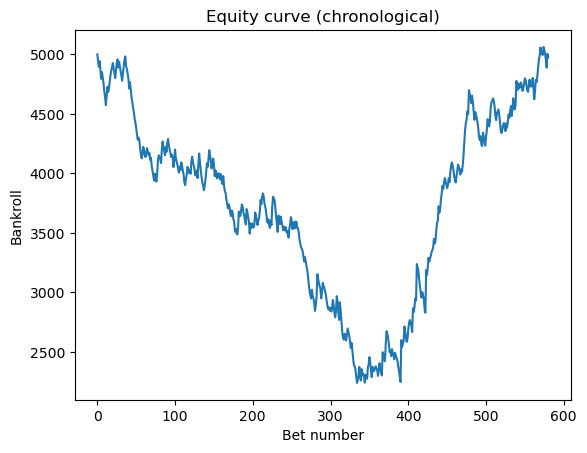

/var/folders/cf/4zyl4dsd16n9yhd_dkhk66gc0000gn/T/ipykernel_30290/412489111.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bt.groupby(["segment", "edge_bin"])


,segment,edge_bin,n_bets,profit,stake,roi
0,Home Favorite,<0–2%,0,0.000000,0.000000,0.000000
1,Home Favorite,2–3%,22,-103.295930,964.675150,-0.107078
2,Home Favorite,3–5%,38,-77.426072,2161.958560,-0.035813
3,Home Favorite,5–8%,53,286.970785,4261.655883,0.067338
4,Home Underdog,<0–2%,0,0.000000,0.000000,0.000000
5,Home Underdog,2–3%,22,100.404690,454.799186,0.220767
6,Home Underdog,3–5%,40,59.116483,1227.998866,0.048141
7,Home Underdog,5–8%,86,-618.308964,4412.393535,-0.140130
8,Road Favorite,<0–2%,0,0.000000,0.000000,0.000000
9,Road Favorite,2–3%,6,65.100339,212.830837,0.305878


edge_bin,<0–2%,2–3%,3–5%,5–8%
segment,,,,
Home Favorite,0.0,-0.107078,-0.035813,0.067338
Home Underdog,0.0,0.220767,0.048141,-0.140130
Road Favorite,0.0,0.305878,0.123372,-0.060046
Road Underdog,0.0,0.042221,-0.194799,0.148829


edge_bin,<0–2%,2–3%,3–5%,5–8%
segment,,,,
Home Favorite,0,22,38,53
Home Underdog,0,22,40,86
Road Favorite,0,6,17,27
Road Underdog,0,40,106,123


In [33]:
import matplotlib.pyplot as plt

print("Backtest summary:")
for k,v in summary.items():
    if isinstance(v, float):
        print(f"  {k:>16}: {v:,.4f}")
    else:
        print(f"  {k:>16}: {v}")

# Equity curve
equity = [BANKROLL0]
bankroll = BANKROLL0
for pnl in df_bt["pnl"].values:
    bankroll += pnl
    equity.append(bankroll)

plt.figure()
plt.plot(equity)
plt.title("Equity curve (chronological)")
plt.xlabel("Bet number")
plt.ylabel("Bankroll")
plt.show()

seg_bin = (
    df_bt.groupby(["segment", "edge_bin"])
         .agg(n_bets=("pnl","size"), profit=("pnl","sum"), stake=("stake","sum"))
         .reset_index()
)
seg_bin["roi"] = np.where(seg_bin["stake"] > 0, seg_bin["profit"] / seg_bin["stake"], 0.0)

display(seg_bin.sort_values(["segment","edge_bin"]))

pivot_roi = seg_bin.pivot(index="segment", columns="edge_bin", values="roi")
pivot_n   = seg_bin.pivot(index="segment", columns="edge_bin", values="n_bets")

display(pivot_roi)
display(pivot_n)

# Uncomment to inspect individual bets
# df_bt.to_csv("nba_backtest_bets.csv", index=False)

/var/folders/cf/4zyl4dsd16n9yhd_dkhk66gc0000gn/T/ipykernel_30290/286081680.py:21: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(seg_bin["edge_bin"]):


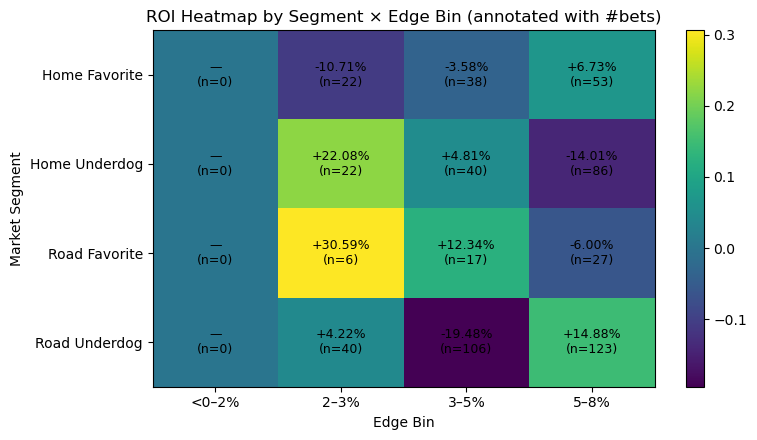

In [34]:
# =========================
# ROI Heatmap by Segment × Edge Bin (annotated with #bets)
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If seg_bin doesn't exist yet, build it from df_bt
if "seg_bin" not in globals():
    seg_bin = (
        df_bt.groupby(["segment", "edge_bin"])
             .agg(n_bets=("pnl","size"), profit=("pnl","sum"), stake=("stake","sum"))
             .reset_index()
    )
    seg_bin["roi"] = np.where(seg_bin["stake"] > 0, seg_bin["profit"] / seg_bin["stake"], np.nan)

# Force a consistent order (match your chart)
segment_order = ["Home Favorite", "Home Underdog", "Road Favorite", "Road Underdog"]

# If your edge bins differ, this will just use whatever is present (sorted by category order if categorical)
if pd.api.types.is_categorical_dtype(seg_bin["edge_bin"]):
    edge_order = list(seg_bin["edge_bin"].cat.categories)
else:
    edge_order = sorted(seg_bin["edge_bin"].dropna().unique(), key=lambda x: str(x))

# Pivot to matrices
roi_mat = seg_bin.pivot(index="segment", columns="edge_bin", values="roi").reindex(index=segment_order, columns=edge_order)
n_mat   = seg_bin.pivot(index="segment", columns="edge_bin", values="n_bets").reindex(index=segment_order, columns=edge_order)

# Build annotation strings
ann = np.empty(roi_mat.shape, dtype=object)
for i in range(roi_mat.shape[0]):
    for j in range(roi_mat.shape[1]):
        roi = roi_mat.iloc[i, j]
        n   = n_mat.iloc[i, j]
        if pd.isna(roi) or pd.isna(n) or n == 0:
            ann[i, j] = "—\n(n=0)"
        else:
            ann[i, j] = f"{roi*100:+.2f}%\n(n={int(n)})"

# Plot
fig_w = max(8, 1.6 * len(edge_order))
fig_h = 4.5
plt.figure(figsize=(fig_w, fig_h))

im = plt.imshow(roi_mat.values, aspect="auto")  # no explicit colors, default colormap

plt.title("ROI Heatmap by Segment × Edge Bin (annotated with #bets)")
plt.xlabel("Edge Bin")
plt.ylabel("Market Segment")

plt.xticks(range(len(edge_order)), [str(x) for x in edge_order])
plt.yticks(range(len(segment_order)), segment_order)

# Annotate cells
for i in range(roi_mat.shape[0]):
    for j in range(roi_mat.shape[1]):
        plt.text(j, i, ann[i, j], ha="center", va="center", fontsize=9)

plt.colorbar(im)
plt.tight_layout()
plt.show()
